In [1]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Load the data
# link to the data below - https://drive.google.com/open?id=1GAVoYBwtb4TK-XaCzgYvUePIvjf-acku
data_raw = pd.read_pickle('./features/data_features_csv-2017.pkl')
data_raw.head(2)

,id,original,number,cdate,tcdate,tmdate,ddate,content,forum,referent,...,details,title,authors,abstract,keywords,replyCount,label,ref_latest,ref_len,ref_years
HJWHIKqgl,HJWHIKqgl,None,494,None,1478297149874,1559850667018,None,"{'authorids': ['dougal@gmail.com', 'htung@cs.c...",HJWHIKqgl,None,...,{'replyCount': 12},Generative Models and Model Criticism via Opti...,"[Dougal J. Sutherland, Hsiao-Yu Tung, Heiko St...",We propose a method to optimize the representa...,[Unsupervised Learning],12,Accept,2019,34,"[2008, 2016, 2011, 2015, 2015, 2008, 2014, 200..."
SyK00v5xx,SyK00v5xx,None,448,None,1478291152993,1544202244497,None,"{'authorids': ['arora@cs.princeton.edu', 'ying...",SyK00v5xx,None,...,{'replyCount': 19},A Simple but Tough-to-Beat Baseline for Senten...,"[Sanjeev Arora, Yingyu Liang, Tengyu Ma]",\nThe success of neural network methods for co...,"[Natural language processing, Unsupervised Lea...",19,Accept,2016,49,"[2012, 2012, 2013, 2013, 2014, 2015, 2016, 200..."


# Preprocessing

#### Contains ML keywords:

In [3]:
def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

#### Contains state-of-the-art

In [4]:
def sota_present(abstract):
    if abstract.lower().find('state-of-the-art') > -1 or abstract.lower().find('state of the art') > -1:
            return 1
    return 0

#### Glove vec average:

In [5]:
embeddings_dict = {}

with open("/home/shruti/data/glove/glove.6B/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
def get_glove_avg(abstract):
    glove_avg = 0
    count = 0
    
    doc = nlp(abstract)
    
    for tok in doc:
        if not tok.is_stop:
            clean_token = tok.text.lower().strip()
            if clean_token in embeddings_dict:
                count += 1
                glove_avg += embeddings_dict[clean_token]
    
    if count > 1:
        return np.mean(glove_avg/count)
    else:
        return np.mean(glove_avg)

#### Avg sentence length of abstract

In [8]:
def avg_abs_sent_length(abstract):
    avg_sent_length = 0
    
    doc = nlp(abstract)
    for s in doc.sents:
        avg_sent_length += len(s)
    
    num_sents = len(list(doc.sents))
    
    if num_sents > 0:
        return avg_sent_length/num_sents
    else:
        return avg_sent_length

#### Number of recent references (last 5 year)

In [9]:
def get_num_recent_refs(list_refs):
    count = 0
    for i in list_refs:
        if int(i) >= 2012:
            count += 1
    return count

#### Loading the new features dict

In [10]:
new_features_from_text = None
with open('./OCR_workspace/feature_dict/2017_features.pkl', "rb") as f:
    new_features_from_text = pickle.load(f)

#### Loading the count of ICLR references featres dict

In [11]:
iclr_refs_count = None
with open('./OCR_workspace/feature_dict/iclr_refs_count.pkl', 'rb') as f:
    iclr_refs_count = pickle.load(f)

#### Avg. ref mention length in chars

In [12]:
def get_avg_ref_mention_length(id):
    year = 2017
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "avg_ref_mention" in new_features_from_text[pid]:
            return new_features_from_text[pid]["avg_ref_mention"]
        else:
            print("Missing avg_ref_mention for: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Number of sections

In [13]:
def get_num_sections(id):
    year = 2017
    pid = id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "num_sections" in new_features_from_text[pid]:
            return new_features_from_text[pid]["num_sections"]
        else:
            return 4
    else:
        print("Missing pid for ", pid)
        return 4

#### Contains appendix

In [14]:
def contains_appendix(id):
    year = 2017
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "contains_appendix" in new_features_from_text[pid]:
            return new_features_from_text[pid]["contains_appendix"]
        else:
            print("Key contains_appendix not present: ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### Count of tables, equations, figures

In [15]:
def get_count_of_fig_table_eqn(id):
    year = 2017
    pid=id
    #pid = "2017" + "_" + id
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and "eqn_ref_count" in new_features_from_text[pid] and "fig_ref_count" in new_features_from_text[pid]:
            total_count = new_features_from_text[pid]["table_ref_count"] + new_features_from_text[pid]["fig_ref_count"] + new_features_from_text[pid]["eqn_ref_count"]
            return total_count
        else:
            print("Keys  count_of_fig_table_eqn keys missing for ", pid)
            return 0
    else:
        print("Missing pid for ", pid)
        return 0

#### contains table

In [16]:
def contains_table(id):
    year = 2017
    pid = id
    
    if pid in new_features_from_text:
        if "table_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["table_ref_count"] and new_features_from_text[pid]["table_ref_count"]>0:
            return 1
    return 0

#### Contains equation(s)

In [17]:
def contains_equation(id):
    year = 2017
    pid = id
    
    if pid in new_features_from_text:
        if "eqn_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["eqn_ref_count"] and new_features_from_text[pid]["eqn_ref_count"]>0:
            return 1
    return 0

#### Contains figure(s)

In [18]:
def contains_figure(id):
    year = 2017
    pid = id
    
    if pid in new_features_from_text:
        if "fig_ref_count" in new_features_from_text[pid] and new_features_from_text[pid]["fig_ref_count"] and new_features_from_text[pid]["fig_ref_count"]>0:
            return 1
    return 0

#### Count of ICLR references

In [19]:
def get_iclr_refs_count(id):
    year = 2017
    pid = "2017_" + id
    if pid in iclr_refs_count:
        return iclr_refs_count[pid]
    return 0

### Feature Matrix Creation

In [20]:
data = pd.DataFrame()
data_raw = data_raw[data_raw['label']!='Invite']
data['id'] = data_raw['id']#.value_counts()
data['n_authors'] = data_raw['authors'].apply(len)#.value_counts()
data['len_char_title'] = data_raw['title'].apply(len)
data['len_word_title'] = data_raw['title'].apply(lambda x: len(re.split(':|\s',x)))
data['len_char_abstract'] = data_raw['abstract'].apply(len)
data['len_word_abstract'] = data_raw['abstract'].apply(lambda x: len(re.split(':|\s',x)))
# data['replyCount'] = data_raw['replyCount']
data['n_keywords'] = data_raw['keywords'].apply(len)
data['ref_len'] = data_raw['ref_len']
data['ref_latest'] = data_raw['ref_latest']
data['contains_ml_keyword'] = data_raw['abstract'].apply(ml_keywords_present)
data['avg_sent_len'] = data_raw['abstract'].apply(avg_abs_sent_length)
data['abs_glove_avg'] = data_raw['abstract'].apply(get_glove_avg)
data['contains_sota'] = data_raw['abstract'].apply(sota_present)
#data.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/data/data-2017-20.pkl')

In [21]:
data['num_recent_refs'] = data_raw['ref_years'].apply(get_num_recent_refs)
data['avg_ref_length'] = data_raw['id'].apply(get_avg_ref_mention_length)
data['num_sections'] = data_raw['id'].apply(get_num_sections)
data['contains_appendix'] = data_raw['id'].apply(contains_appendix)
data['fig_tab_eqn_count'] = data_raw['id'].apply(get_count_of_fig_table_eqn)
data['contains_table'] = data_raw['id'].apply(contains_table)
data['contains_figure'] = data_raw['id'].apply(contains_figure)
data['contains_equation'] = data_raw['id'].apply(contains_equation)
data['iclr_references'] = data_raw['id'].apply(get_iclr_refs_count)


data['label'] = data_raw['label']

data.head(2)

Key contains_appendix not present:  r1Usiwcex
Keys  count_of_fig_table_eqn keys missing for  r1Usiwcex


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
HJWHIKqgl,HJWHIKqgl,7,76,10,996,160,1,34,2019,1,...,21,216,6,1,18,0,1,0,3,Accept
SyK00v5xx,SyK00v5xx,3,59,8,1611,253,2,49,2016,1,...,35,28,12,1,16,1,1,1,1,Accept


In [22]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label


In [23]:
data['label'].unique()

array(['Accept', 'Reject'], dtype=object)

In [94]:
data.to_pickle('./features/all_data_features_csv_2017_new.pkl')

## Read features directly

In [2]:
# data.to_pickle('./features/all_data_features_csv_2017_new.pkl')
data = pd.read_pickle('./features/all_data_features_csv_2017_new.pkl')
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
HyenWc5gx,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,27,19,20,1,8,1,0,1,0,Reject
Hk8TGSKlg,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,14,47,16,1,2,1,1,1,0,Accept


In [3]:
data.columns

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg',
       'contains_sota', 'num_recent_refs', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label'],
      dtype='object')

In [3]:
with open("./features/rev_aspects_2017_peerread.pkl", "rb") as f:
    aspect_scores = pickle.load(f)

In [4]:
def get_mc(pid):
    if pid in aspect_scores:
        if "MEANINGFUL_COMPARISON" in aspect_scores[pid] and aspect_scores[pid]["MEANINGFUL_COMPARISON"]:
            return sum(aspect_scores[pid]["MEANINGFUL_COMPARISON"])/len(aspect_scores[pid]["MEANINGFUL_COMPARISON"])
    return 0

data["MEANINGFUL_COMPARISON"] = data['id'].apply(get_mc)
(data["MEANINGFUL_COMPARISON"] == 0).sum()

408

In [5]:
def get_impact(pid):
    if pid in aspect_scores:
        if "IMPACT" in aspect_scores[pid] and aspect_scores[pid]["IMPACT"]:
            return sum(aspect_scores[pid]["IMPACT"])/len(aspect_scores[pid]["IMPACT"])
    return 0

data["IMPACT"] = data['id'].apply(get_impact)
(data["IMPACT"] == 0).sum()

379

In [6]:
def get_org(pid):
    if pid in aspect_scores:
        if "ORIGINALITY" in aspect_scores[pid] and aspect_scores[pid]["ORIGINALITY"]:
            return sum(aspect_scores[pid]["ORIGINALITY"])/len(aspect_scores[pid]["ORIGINALITY"])
    return 0

data["ORIGINALITY"] = data['id'].apply(get_org)
(data["ORIGINALITY"] == 0).sum()

355

In [7]:
def get_substance(pid):
    if pid in aspect_scores:
        if "SUBSTANCE" in aspect_scores[pid] and aspect_scores[pid]["SUBSTANCE"]:
            return sum(aspect_scores[pid]["SUBSTANCE"])/len(aspect_scores[pid]["SUBSTANCE"])
    return 0

data["SUBSTANCE"] = data['id'].apply(get_substance)
(data["SUBSTANCE"] == 0).sum()

396

In [8]:
def get_soundness(pid):
    if pid in aspect_scores:
        if "SOUNDNESS_CORRECTNESS" in aspect_scores[pid] and aspect_scores[pid]["SOUNDNESS_CORRECTNESS"]:
            return sum(aspect_scores[pid]["SOUNDNESS_CORRECTNESS"])/len(aspect_scores[pid]["SOUNDNESS_CORRECTNESS"])
    return 0

data["SOUNDNESS_CORRECTNESS"] = data['id'].apply(get_soundness)
(data["SOUNDNESS_CORRECTNESS"] == 0).sum()

369

In [9]:
def get_appnes(pid):
    if pid in aspect_scores:
        if "APPROPRIATENESS" in aspect_scores[pid] and aspect_scores[pid]["APPROPRIATENESS"]:
            return sum(aspect_scores[pid]["APPROPRIATENESS"])/len(aspect_scores[pid]["APPROPRIATENESS"])
    return 0

data["APPROPRIATENESS"] = data['id'].apply(get_appnes)
(data["APPROPRIATENESS"] == 0).sum()

430

In [10]:
def get_clarity(pid):
    if pid in aspect_scores:
        if "CLARITY" in aspect_scores[pid] and aspect_scores[pid]["CLARITY"]:
            return sum(aspect_scores[pid]["CLARITY"])/len(aspect_scores[pid]["CLARITY"])
    return 0

data["CLARITY"] = data['id'].apply(get_clarity)
(data["CLARITY"] == 0).sum()

364

In [11]:
len(data)

443

In [13]:
data.to_pickle('./features/all_data_features_csv_2017_with_aspect_scores.pkl')
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,contains_equation,iclr_references,label,MEANINGFUL_COMPARISON,IMPACT,ORIGINALITY,SUBSTANCE,SOUNDNESS_CORRECTNESS,APPROPRIATENESS,CLARITY
HyenWc5gx,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,1,0,Reject,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hk8TGSKlg,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,1,0,Accept,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# shuffle the data
data = data.sample(n=len(data), random_state=42)
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,contains_equation,iclr_references,label,MEANINGFUL_COMPARISON,IMPACT,ORIGINALITY,SUBSTANCE,SOUNDNESS_CORRECTNESS,APPROPRIATENESS,CLARITY
SyVVJ85lg,SyVVJ85lg,3,51,9,1344,188,1,25,2016,1,...,0,1,Accept,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HJjiFK5gx,HJjiFK5gx,5,23,3,869,129,2,31,2017,0,...,1,1,Accept,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
  dot_data = StringIO()
  tree.export_graphviz(clf[0], 
  out_file=dot_data, 
  class_names=['Accept','Reject'], # the target names.
  feature_names=X.columns, # the feature names.
  filled=True, # Whether to fill in the boxes with colours.
  rounded=True, # Whether to round the corners of the boxes.
  special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return Image(graph.create_png())

# All models

In [4]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=5000),
            'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=5000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

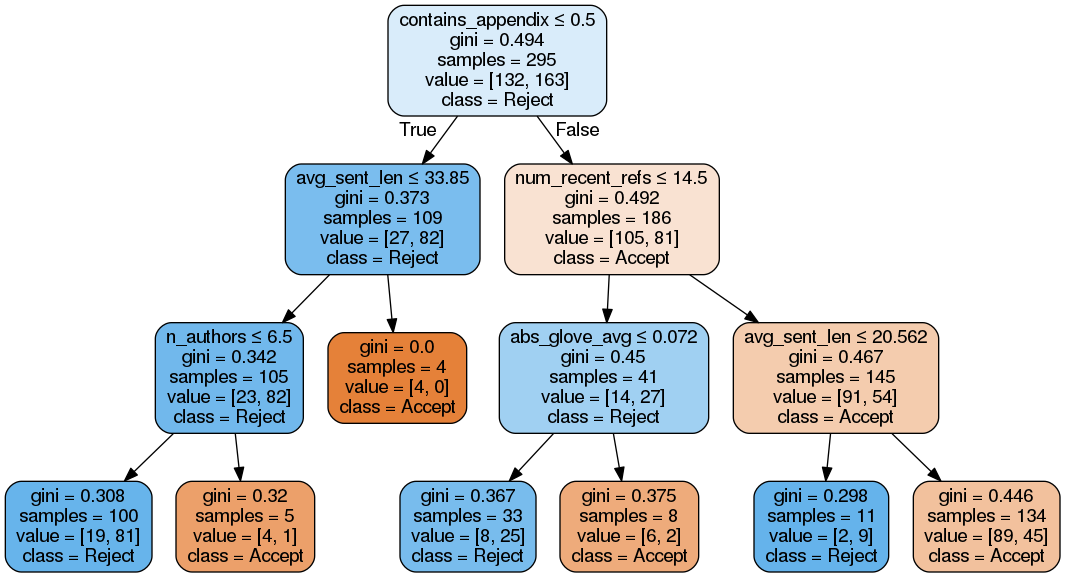

In [90]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
  X = data.drop(columns=['id','label'])
  y = data['label']
  results = cross_validate(clf, X, y, return_estimator=True)
  clf = results['estimator']
  results.pop('estimator')
  accuracy = np.mean(results['test_score'])
  model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
  if clf_name == 'DecisionTree':
    display(plot(clf))

In [91]:
# Model results with all the new features without normalization
model_results

,Accuracy,CVresults
RandomForest,0.595958,"{'fit_time': [0.017012596130371094, 0.00970125..."
DecisionTree,0.584728,"{'fit_time': [0.0021431446075439453, 0.0020916..."
RidgeClf,0.638904,"{'fit_time': [0.004420757293701172, 0.00370192..."
KNN,0.5057,"{'fit_time': [0.002615690231323242, 0.00254273..."
GaussianProcessClf,0.514739,"{'fit_time': [0.10168957710266113, 0.201512575..."
GaussNB,0.643347,"{'fit_time': [0.004263639450073242, 0.00409555..."
NeuralNet,0.559815,"{'fit_time': [0.4534769058227539, 0.4280405044..."
LogisticR,0.643424,"{'fit_time': [0.014331340789794922, 0.01160144..."
SVC,0.553043,"{'fit_time': [0.015288352966308594, 0.01434087..."
LogisticLassoR,0.641141,"{'fit_time': [0.03127861022949219, 0.026750087..."


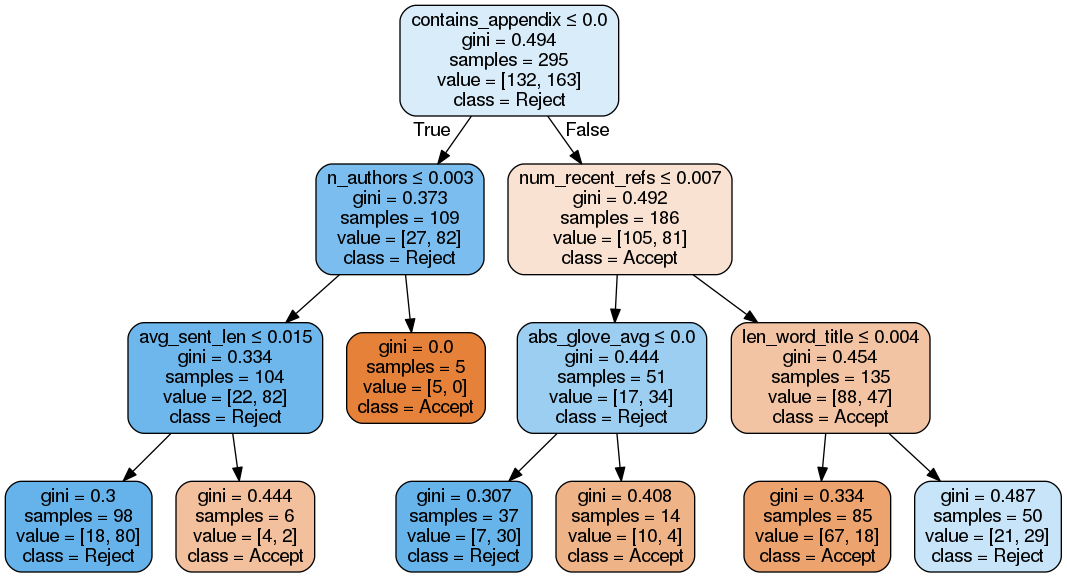

In [92]:
# Model results with all the new features with normalization
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

#X = data.drop(columns=['id','label'])
#X = data.drop(columns=['id','label', 'contains_equation', 'contains_table', 'contains_figure'])

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))
#     X = data.drop(columns=['id','label']
#     y = data['label']
#     X_normalized = normalize(X)
#     results = cross_validate(clf, X_normalized, y, return_estimator=True)
#     clf = results['estimator']
#     results.pop('estimator')
#     accuracy = np.mean(results['test_score'])
#     model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == 'DecisionTree':
#         display(plot(clf))


In [93]:
model_results

,Accuracy,CVresults
RandomForest,0.573466,"{'fit_time': [0.009111404418945312, 0.00874495..."
DecisionTree,0.58701,"{'fit_time': [0.0016658306121826172, 0.0016067..."
RidgeClf,0.553043,"{'fit_time': [0.0032753944396972656, 0.0019793..."
KNN,0.512487,"{'fit_time': [0.0009036064147949219, 0.0008864..."
GaussianProcessClf,0.553043,"{'fit_time': [1.7917203903198242, 1.3819715976..."
GaussNB,0.643378,"{'fit_time': [0.012610197067260742, 0.00201725..."
NeuralNet,0.553043,"{'fit_time': [0.061434030532836914, 0.04442906..."
LogisticR,0.553043,"{'fit_time': [0.0031425952911376953, 0.0025987..."
SVC,0.553043,"{'fit_time': [0.011078119277954102, 0.01112174..."
LogisticLassoR,0.553043,"{'fit_time': [0.0026831626892089844, 0.0021121..."


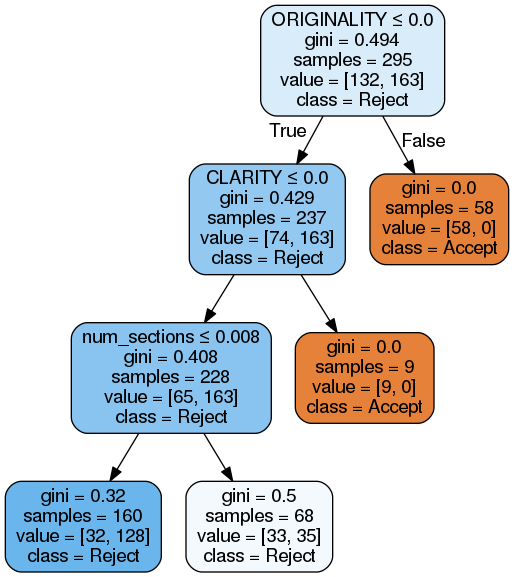

In [38]:
# Model results with all the new features with normalization
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

#X = data.drop(columns=['id','label'])
#X = data.drop(columns=['id','label', 'contains_equation', 'contains_table', 'contains_figure'])

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [16]:
# Old results for doc sake
model_results

,Accuracy,CVresults
LogisticLassoR,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
LogisticR,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
DecisionTree,0.600447,"{'test_score': [0.6013513513513513, 0.60135135..."
NeuralNet,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
GaussNB,0.620794,"{'test_score': [0.6554054054054054, 0.57432432..."
KNN,0.54624,"{'test_score': [0.6216216216216216, 0.48648648..."
RandomForest,0.600401,"{'test_score': [0.6418918918918919, 0.58108108..."
GaussianProcessClf,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
RidgeClf,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."


In [39]:
model_results

,Accuracy,CVresults
LogisticLassoR,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
LogisticR,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
DecisionTree,0.771925,"{'test_score': [0.7837837837837838, 0.79729729..."
NeuralNet,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
GaussNB,0.792211,"{'test_score': [0.7972972972972973, 0.83783783..."
KNN,0.528314,"{'test_score': [0.5067567567567568, 0.50675675..."
RandomForest,0.749402,"{'test_score': [0.777027027027027, 0.736486486..."
GaussianProcessClf,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
RidgeClf,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."


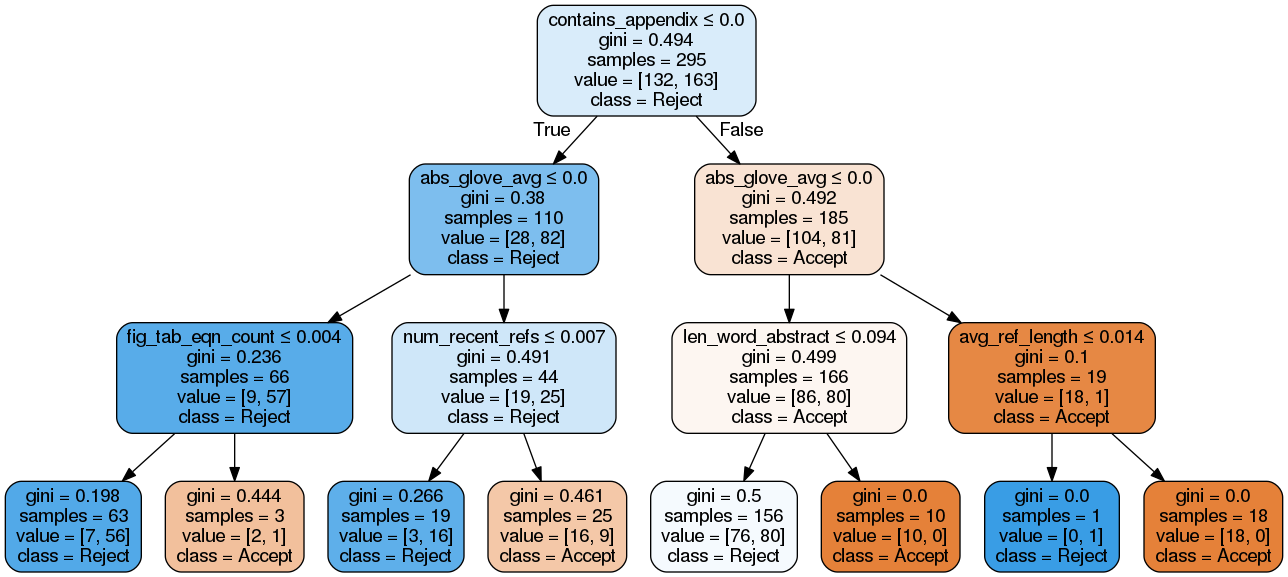

In [41]:
# Model results with all the new features with normalization
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

#X = data.drop(columns=['id','label'])
#X = data.drop(columns=['id','label', 'contains_equation', 'contains_table', 'contains_figure'])

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', "MEANINGFUL_COMPARISON", "IMPACT", "ORIGINALITY", "SUBSTANCE", "SOUNDNESS_CORRECTNESS", "APPROPRIATENESS", "CLARITY"])
    y = data['label']
    X_normalized = normalize(X)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [42]:
model_results

,Accuracy,CVresults
LogisticLassoR,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
LogisticR,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
DecisionTree,0.548508,"{'test_score': [0.5135135135135135, 0.59459459..."
NeuralNet,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
GaussNB,0.604937,"{'test_score': [0.6148648648648649, 0.60810810..."
KNN,0.523794,"{'test_score': [0.5, 0.5067567567567568, 0.564..."
RandomForest,0.598149,"{'test_score': [0.6216216216216216, 0.59459459..."
GaussianProcessClf,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
RidgeClf,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."


### To update in md format

In [56]:
# Copy the results into .md file to visualize the table in .md
model_results.drop(columns=['CVresults']).to_html().replace('\n','')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Accuracy</th>    </tr>  </thead>  <tbody>    <tr>      <th>RandomForest</th>      <td>0.582491</td>    </tr>    <tr>      <th>DecisionTree</th>      <td>0.589278</td>    </tr>    <tr>      <th>RidgeClf</th>      <td>0.553043</td>    </tr>    <tr>      <th>KNN</th>      <td>0.512487</td>    </tr>    <tr>      <th>GaussianProcessClf</th>      <td>0.553043</td>    </tr>    <tr>      <th>GaussNB</th>      <td>0.656892</td>    </tr>    <tr>      <th>NeuralNet</th>      <td>0.553043</td>    </tr>    <tr>      <th>LogisticR</th>      <td>0.553043</td>    </tr>    <tr>      <th>SVC</th>      <td>0.553043</td>    </tr>    <tr>      <th>LogisticLassoR</th>      <td>0.553043</td>    </tr>  </tbody></table>'

## PCA

In [3]:
from sklearn.decomposition import PCA

In [5]:
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
HyenWc5gx,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,27,19,20,1,8,1,0,1,0,Reject
Hk8TGSKlg,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,14,47,16,1,2,1,1,1,0,Accept


In [14]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
    out_file=dot_data, 
    class_names=['Accept','Reject'], # the target names.
    feature_names=X.columns, # the feature names.
    filled=True, # Whether to fill in the boxes with colours.
    rounded=True, # Whether to round the corners of the boxes.
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

In [15]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=5000),
            'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=5000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

In [43]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == 'DecisionTree':
#         display(plot(clf))

In [44]:
model_results

,Accuracy,CVresults
GaussianProcessClf,0.514739,"{'test_score': [0.5337837837837838, 0.46621621..."
NeuralNet,0.534979,"{'test_score': [0.5067567567567568, 0.56756756..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
GaussNB,0.643347,"{'test_score': [0.6148648648648649, 0.66891891..."
LogisticLassoR,0.641141,"{'test_score': [0.6148648648648649, 0.64189189..."
RidgeClf,0.638904,"{'test_score': [0.6013513513513513, 0.64189189..."
KNN,0.5057,"{'test_score': [0.46621621621621623, 0.5202702..."
RandomForest,0.613915,"{'test_score': [0.6621621621621622, 0.60135135..."
DecisionTree,0.584728,"{'test_score': [0.5540540540540541, 0.58108108..."
LogisticR,0.643424,"{'test_score': [0.6081081081081081, 0.64189189..."


In [78]:
X_red = data.drop(columns=['id','label'])
X_red = np.array(X)
pca = PCA(n_components=6)

In [79]:
xpca = pca.fit_transform(X_red)

In [80]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#     X_normalized = normalize(xpca)
    y = data['label']
    results = cross_validate(clf, xpca, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == 'DecisionTree':
#         display(plot(clf))

In [81]:
xpca.shape

(443, 6)

In [82]:
model_results

,Accuracy,CVresults
GaussianProcessClf,0.519244,"{'test_score': [0.5337837837837838, 0.47972972..."
NeuralNet,0.573482,"{'test_score': [0.5472972972972973, 0.54729729..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
GaussNB,0.620825,"{'test_score': [0.581081081081081, 0.635135135..."
LogisticLassoR,0.611785,"{'test_score': [0.5743243243243243, 0.62837837..."
RidgeClf,0.61177,"{'test_score': [0.581081081081081, 0.628378378..."
KNN,0.519244,"{'test_score': [0.49324324324324326, 0.5202702..."
RandomForest,0.553181,"{'test_score': [0.5, 0.5472972972972973, 0.612..."
DecisionTree,0.555418,"{'test_score': [0.5067567567567568, 0.55405405..."
LogisticR,0.61177,"{'test_score': [0.5743243243243243, 0.63513513..."


## Adding MAG features author pub and citation count

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_pickle('./features/all_data_features_csv_2017_new.pkl')
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
HyenWc5gx,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,27,19,20,1,8,1,0,1,0,Reject
Hk8TGSKlg,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,14,47,16,1,2,1,1,1,0,Accept


In [148]:
# shuffle the data
data = data.sample(frac=1, random_state=42)
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
SJ25-B5eg,SJ25-B5eg,5,24,4,953,138,3,39,2016,1,...,26,36,14,1,7,1,0,1,2,Accept
rkFd2P5gl,rkFd2P5gl,3,72,9,1266,178,1,25,2016,1,...,12,26,19,0,1,1,1,0,0,Reject


In [4]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
    out_file=dot_data, 
    class_names=['Accept','Reject'], # the target names.
    feature_names=X.columns, # the feature names.
    filled=True, # Whether to fill in the boxes with colours.
    rounded=True, # Whether to round the corners of the boxes.
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

In [5]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=8000),
            'LogisticLassoR':LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=8000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((100),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

In [6]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == 'DecisionTree':
#         display(plot(clf))

In [7]:
model_results

,Accuracy,CVresults
GaussNB,0.643347,"{'test_score': [0.6148648648648649, 0.66891891..."
RidgeClf,0.638904,"{'test_score': [0.6013513513513513, 0.64189189..."
LogisticR,0.643424,"{'test_score': [0.6081081081081081, 0.64189189..."
LogisticLassoR,0.641141,"{'test_score': [0.6148648648648649, 0.64189189..."
NeuralNet,0.568962,"{'test_score': [0.5608108108108109, 0.52702702..."
GaussianProcessClf,0.514739,"{'test_score': [0.5337837837837838, 0.46621621..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
DecisionTree,0.584728,"{'test_score': [0.5540540540540541, 0.58108108..."
RandomForest,0.600585,"{'test_score': [0.581081081081081, 0.560810810..."
KNN,0.5057,"{'test_score': [0.46621621621621623, 0.5202702..."


### pub count and citat feats

In [8]:
with open('./features/mag_features_2017_iclr.pickle', 'rb') as handle:
    mag_feats = pickle.load(handle)

In [9]:
def get_mean_pub(pid):
    if pid in mag_feats:
        if "num_pubs" in mag_feats[pid] and mag_feats[pid]["num_pubs"]:
            return np.mean(mag_feats[pid]["num_pubs"])
    return 0

def get_median_pub(pid):
    if pid in mag_feats:
        if "num_pubs" in mag_feats[pid] and mag_feats[pid]["num_pubs"]:
            return np.median(mag_feats[pid]["num_pubs"])
    return 0

def get_max_pub(pid):
    if pid in mag_feats:
        if "num_pubs" in mag_feats[pid] and mag_feats[pid]["num_pubs"]:
            return np.max(mag_feats[pid]["num_pubs"])
    return 0

In [10]:
def get_mean_cit(pid):
    if pid in mag_feats:
        if "num_cits" in mag_feats[pid] and mag_feats[pid]["num_cits"]:
            return np.mean(mag_feats[pid]["num_cits"])
    return 0

def get_median_cit(pid):
    if pid in mag_feats:
        if "num_cits" in mag_feats[pid] and mag_feats[pid]["num_cits"]:
            return np.median(mag_feats[pid]["num_cits"])
    return 0

def get_max_cit(pid):
    if pid in mag_feats:
        if "num_cits" in mag_feats[pid] and mag_feats[pid]["num_cits"]:
            return np.max(mag_feats[pid]["num_cits"])
    return 0

In [24]:
data['mean_pub'] = data['id'].apply(get_mean_pub)
data['max_pub'] = data['id'].apply(get_max_pub)
data['med_pub'] = data['id'].apply(get_median_pub)

data['mean_cit'] = data['id'].apply(get_mean_cit)
data['max_cit'] = data['id'].apply(get_max_cit)
data['med_cit'] = data['id'].apply(get_median_cit)

In [25]:
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,contains_figure,contains_equation,iclr_references,label,max_pub,max_cit,mean_pub,med_pub,mean_cit,med_cit
HyenWc5gx,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,0,1,0,Reject,83,1908,34.666667,11.0,646.0,16.0
Hk8TGSKlg,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,1,1,0,Accept,113,3062,57.500000,57.5,1534.5,1534.5


In [13]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
#     if clf_name == 'DecisionTree':
#         display(plot(clf))

In [14]:
model_results

,Accuracy,CVresults
GaussNB,0.632086,"{'test_score': [0.6013513513513513, 0.64864864..."
RidgeClf,0.62988,"{'test_score': [0.581081081081081, 0.641891891..."
LogisticR,0.629849,"{'test_score': [0.5945945945945946, 0.64189189..."
LogisticLassoR,0.62536,"{'test_score': [0.5945945945945946, 0.62162162..."
NeuralNet,0.600447,"{'test_score': [0.5945945945945946, 0.60810810..."
GaussianProcessClf,0.446957,"{'test_score': [0.4391891891891892, 0.45270270..."
SVC,0.553043,"{'test_score': [0.5540540540540541, 0.55405405..."
DecisionTree,0.566694,"{'test_score': [0.527027027027027, 0.560810810..."
RandomForest,0.611785,"{'test_score': [0.6081081081081081, 0.59459459..."
KNN,0.595912,"{'test_score': [0.6351351351351351, 0.56756756..."


In [17]:
data.drop(columns=["max_pub", "max_cit"])
data.to_csv("reproducible_dataset_iclr2017.csv", encoding='utf-8', index=False)
# pd.read_csv("reproducible_dataset_iclr2017.csv")

In [29]:
#count non zero rows in mag features
print((data['max_pub'] != 0).sum(), (data['max_cit'] != 0).sum())
print(data.astype(bool).sum(axis=0))

440 428
id                     443
n_authors              443
len_char_title         442
len_word_title         443
len_char_abstract      443
len_word_abstract      443
n_keywords             352
ref_len                441
ref_latest             443
contains_ml_keyword    318
avg_sent_len           443
abs_glove_avg          442
contains_sota          119
num_recent_refs        438
avg_ref_length         440
num_sections           443
contains_appendix      274
fig_tab_eqn_count      352
contains_table         352
contains_figure        430
contains_equation      244
iclr_references        199
label                  443
max_pub                440
max_cit                428
mean_pub               440
med_pub                440
mean_cit               428
med_cit                427
dtype: int64


In [5]:
# Model results with all the new features with normalization
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

#X = data.drop(columns=['id','label'])
#X = data.drop(columns=['id','label', 'contains_equation', 'contains_table', 'contains_figure'])

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label'])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]


In [6]:
model_results

,Accuracy,CVresults
GaussianProcessClf,0.643409,"{'score_time': [0.014711380004882812, 0.015098..."
GaussNB,0.6456,"{'score_time': [0.003426790237426758, 0.003225..."
RidgeClf,0.627612,"{'score_time': [0.0017178058624267578, 0.00154..."
RandomForest,0.605028,"{'score_time': [0.0031571388244628906, 0.00310..."
LogisticR,0.638935,"{'score_time': [0.0018210411071777344, 0.00168..."
DecisionTree,0.584728,"{'score_time': [0.0017631053924560547, 0.00167..."
KNN,0.61632,"{'score_time': [0.011114358901977539, 0.010125..."
NeuralNet,0.625375,"{'score_time': [0.0044057369232177734, 0.00444..."
SVC,0.602822,"{'score_time': [0.0089874267578125, 0.00939631..."
LogisticLassoR,0.63892,"{'score_time': [0.0028319358825683594, 0.00178..."


In [7]:
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_recent_refs,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label
HyenWc5gx,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,27,19,20,1,8,1,0,1,0,Reject
Hk8TGSKlg,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,14,47,16,1,2,1,1,1,0,Accept


In [11]:
cols = list(data.columns)
print(cols)

['id', 'n_authors', 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len', 'ref_latest', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg', 'contains_sota', 'num_recent_refs', 'avg_ref_length', 'num_sections', 'contains_appendix', 'fig_tab_eqn_count', 'contains_table', 'contains_figure', 'contains_equation', 'iclr_references', 'label']


In [12]:
cols.remove("id")
cols.remove("label")

In [35]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
# model_results['feature'] = None


for column_leave in cols:
    X = data.drop(columns=['id', 'label', column_leave])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear')
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[column_leave, ['Accuracy']] = [accuracy]


In [36]:
model_results

,Accuracy
n_authors,0.641172
len_char_title,0.638920
len_word_title,0.643424
len_char_abstract,0.638920
len_word_abstract,0.638920
n_keywords,0.638920
ref_len,0.629880
ref_latest,0.638920
contains_ml_keyword,0.632209
avg_sent_len,0.638920


In [37]:
model_results.sort_values(by=["Accuracy"])

,Accuracy
contains_appendix,0.629849
ref_len,0.629880
contains_ml_keyword,0.632209
abs_glove_avg,0.634369
contains_sota,0.634384
contains_figure,0.638920
fig_tab_eqn_count,0.638920
num_sections,0.638920
avg_ref_length,0.638920
iclr_references,0.638920


In [18]:
X = data.drop(columns=['id', 'label'])
y = data['label']
X_normalized = X / X.max(axis=0)
clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear')
results = cross_validate(clf, X_normalized, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
print(accuracy)
# model_results.loc[clf, ['Accuracy']] = [accuracy]


0.6389195317766746


In [34]:
X = data.drop(columns=['id', 'label'])
y = data['label']
X_normalized = X / X.max(axis=0)
clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear')
results = cross_validate(clf, X_normalized, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
# print(accuracy)

clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear').fit(X_normalized, y)
y_predicted = clf.predict(X_normalized)
# print(balanced_accuracy_score(y, y_predicted))
print(classification_report(y, y_predicted, target_names=["Reject", "Accept"]))

              precision    recall  f1-score   support

      Reject       0.62      0.58      0.60       198
      Accept       0.68      0.72      0.70       245

    accuracy                           0.65       443
   macro avg       0.65      0.65      0.65       443
weighted avg       0.65      0.65      0.65       443



In [28]:
from sklearn.metrics import balanced_accuracy_score, classification_report

In [31]:
y.head()

HyenWc5gx    Reject
Hk8TGSKlg    Accept
HkIQH7qel    Reject
SkBsEQYll    Reject
rkE8pVcle    Accept
Name: label, dtype: object